In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. Load data
# ------------------------------------------------------------------
df = pd.read_csv("Testing Measurements - Distance Pleated.csv")
df2 = pd.read_csv("Testing Measurements 2.csv")

# Spiral identifier and the columns that hold the turn-by-turn distances
spiral_col   = "Spiral Type"
turn_cols    = df.columns.to_list()[2:] # <- edit if needed
n_turns      = 5   # denominator for the rate-of-change calc (final – initial) / n_turns

turn_cols2 = df2.columns.to_list()[2:]

# subtract the first turn from all turns
df[turn_cols] = df[turn_cols].sub(df[turn_cols].iloc[:, 0], axis=0)
df2[turn_cols2] = df2[turn_cols2].sub(df2[turn_cols2].iloc[:, 0], axis=0)



# ------------------------------------------------------------------
# 2. Aggregate: mean, std, and SEM for every spiral at every turn
# ------------------------------------------------------------------
agg = (
    df.groupby(spiral_col)[turn_cols]
      .agg(["mean", "std", "count"])
)
# tidy column index: agg["turn_0"]["mean"] → agg_mean.loc[:,"turn_0"]
agg_mean = agg.xs("mean", level=1, axis=1)
agg_std  = agg.xs("std",  level=1, axis=1)
agg_sem  = agg_std / np.sqrt(agg.xs("count", level=1, axis=1))

# ------------------------------------------------------------------
# 2. Aggregate: mean, std, and SEM for every spiral at every turn
# ------------------------------------------------------------------
agg2 = (
    df2.groupby(spiral_col)[turn_cols2]
      .agg(["mean", "std", "count"])
)
# tidy column index: agg["turn_0"]["mean"] → agg_mean.loc[:,"turn_0"]
agg_mean2 = agg2.xs("mean", level=1, axis=1)
agg_std2  = agg2.xs("std",  level=1, axis=1)
agg_sem2  = agg_std2 / np.sqrt(agg2.xs("count", level=1, axis=1))




In [2]:
print(agg_std)

                                  0        5        10        15        20  \
Spiral Type                                                                  
 Solid (Large Pitch)            NaN      NaN       NaN       NaN       NaN   
Inflatable Inflatable           NaN      NaN       NaN       NaN       NaN   
Inflatable Solid (Large Pitch)  0.0  1.06066  0.000000  1.343503  0.494975   
Medical Spiral                  NaN      NaN       NaN       NaN       NaN   
Solid (Large Pitch)             0.0  0.50000  0.448144  0.312250  1.311488   

                                      25  
Spiral Type                               
 Solid (Large Pitch)                 NaN  
Inflatable Inflatable                NaN  
Inflatable Solid (Large Pitch)  0.707107  
Medical Spiral                       NaN  
Solid (Large Pitch)             0.435890  


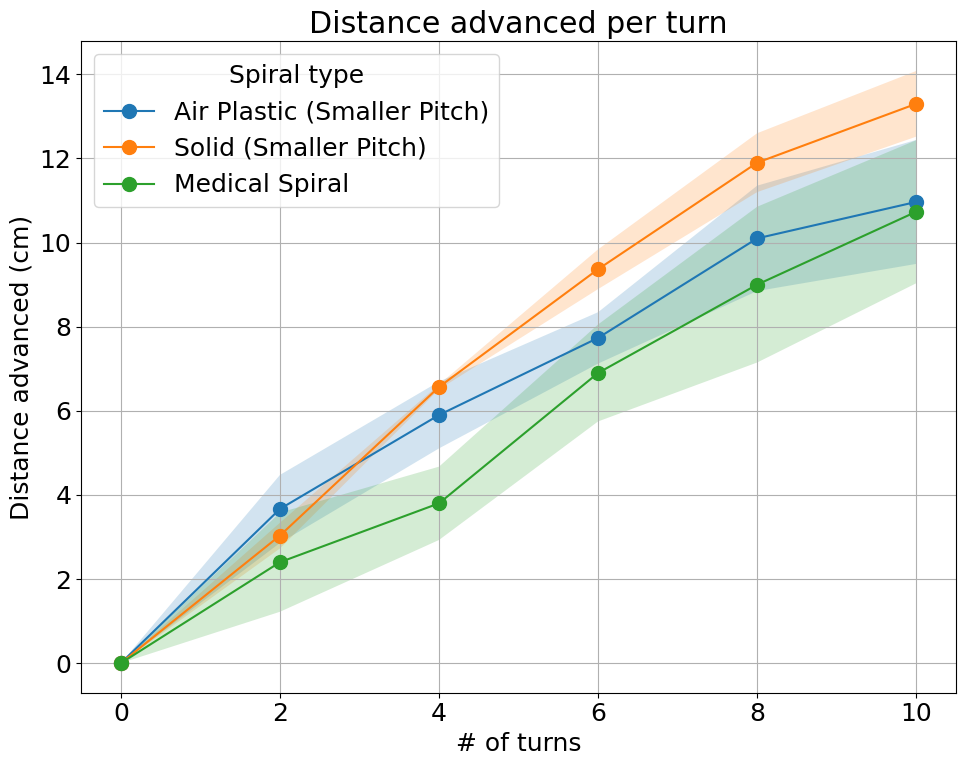

In [3]:
# ------------------------------------------------------------------
# 3. LINE PLOT — distance vs. turn, with ±1 SD shaded
# ------------------------------------------------------------------
plt.figure(figsize=(10,8))
plt.rcParams['font.size'] = 18
spirals1 = ['Inflatable Solid (Large Pitch)', 'Solid (Large Pitch)']
spirals2 = ['Air Plastic (Smaller Pitch)', 'Solid (Smaller Pitch)', 'Medical Spiral']

# turn turn_cols into a list of numbers
turn_numbers = [int(col) for col in turn_cols]
turn_numbers2 = [int(col) for col in turn_cols2]

# for s in spirals1:
#     mean_series = agg_mean.loc[s].values
#     mean_series = mean_series - mean_series[0]
#     std_series  = agg_std .loc[s].values
    
#     plt.plot(turn_numbers, mean_series, label=s, marker='o', markersize=10)
#     plt.fill_between(turn_numbers,
#                      mean_series - std_series,
#                      mean_series + std_series,
#                      alpha=0.2)
#         # ❷ big dots + vertical error bars on each measured turn

for s in spirals2:
    mean_series = agg_mean2.loc[s].values
    mean_series = mean_series - mean_series[0]
    std_series  = agg_std2 .loc[s].values
    
    plt.plot(turn_numbers2, mean_series, label=s, marker='o', markersize=10)
    plt.fill_between(turn_numbers2,
                     mean_series - std_series,
                     mean_series + std_series,
                     alpha=0.2)
        # ❷ big dots + vertical error bars on each measured turn

plt.xlabel("# of turns")
plt.ylabel("Distance advanced (cm)")
plt.title("Distance advanced per turn")
plt.legend(title="Spiral type", loc="upper left")
plt.tight_layout()
plt.grid()
plt.savefig('Pleating Distance Vs. Turns.png')

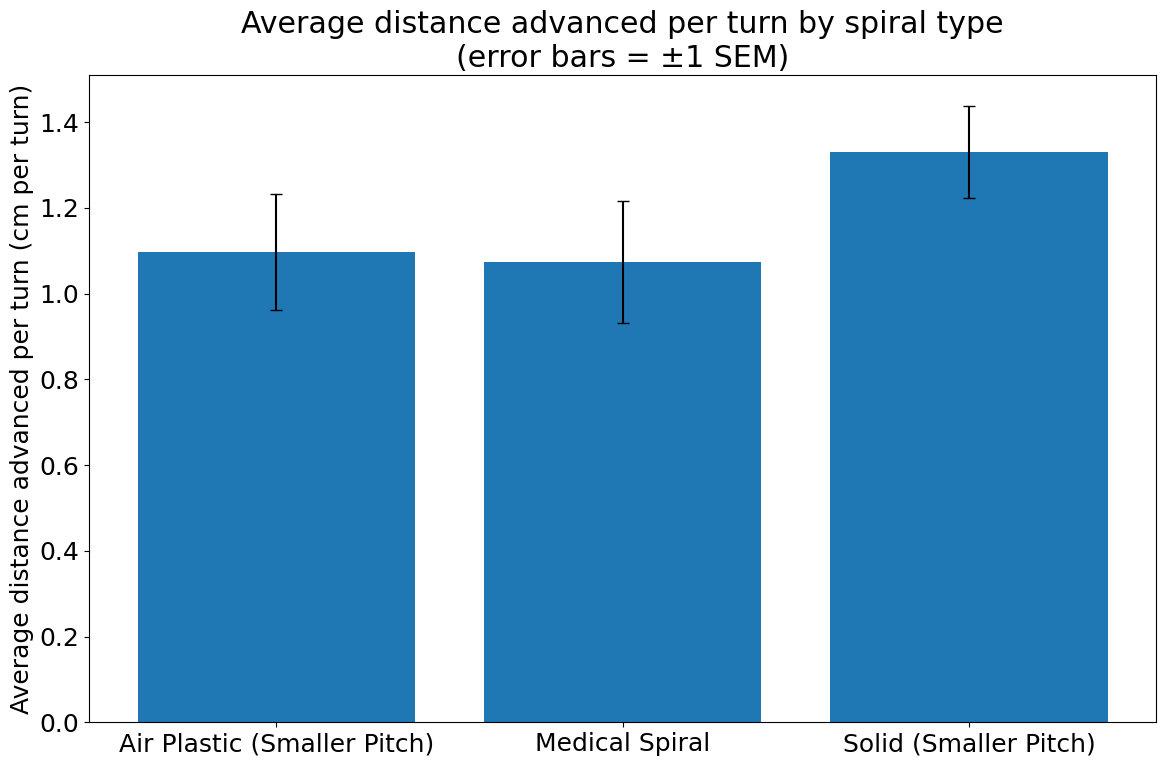

In [4]:
# ------------------------------------------------------------------
# 4-ALT.  BAR PLOT — mean of *all* per-turn rates  (±1 SEM)
# ------------------------------------------------------------------
# ❶  Calculate the change between every consecutive turn for each row

diff_df2 = df2[df2['Spiral Type'].isin(spirals2)][turn_cols2].diff(axis=1).iloc[:, 1:]     # drop NaNs from turn_0
#             ↑ turn_1–turn_0, turn_2–turn_1, …, turn_5–turn_4
#     each column is a single-turn increment (cm  per turn)

diff_df2 = diff_df2 / 2 # divide by 2 because we're looking at 2 turns

# Give those new columns sensible names
# Give those new columns sensible names
diff_df2.columns = [f"rate_{i}_{i+1}" for i in range(len(turn_cols)-1)]

# Attach the spiral_type back so we can group by it
rates_long = pd.concat([df2[[spiral_col]], diff_df2], axis=1) \
               .melt(id_vars=spiral_col,      # keep the spiral label
                     value_vars=diff_df2.columns,
                     var_name="interval",     # e.g. rate_1_2
                     value_name="rate")       # the numeric change

# ❷  Group by spiral and compute mean, SD, SEM of *all* these rates
rate_stats = (
    rates_long.groupby(spiral_col)["rate"]
              .agg(["mean", "std", "count"])
)
rate_stats["sem"] = rate_stats["std"] / np.sqrt(rate_stats["count"])

# ❸  Plot the bar chart
plt.figure(figsize=(12,8))
plt.bar(rate_stats.index,
        rate_stats["mean"],
        yerr=rate_stats["sem"],
        capsize=4)

plt.ylabel("Average distance advanced per turn (cm per turn)")
plt.title("Average distance advanced per turn by spiral type\n(error bars = ±1 SEM)")
plt.tight_layout()
plt.savefig('Rate of Change by Spiral Type.png')


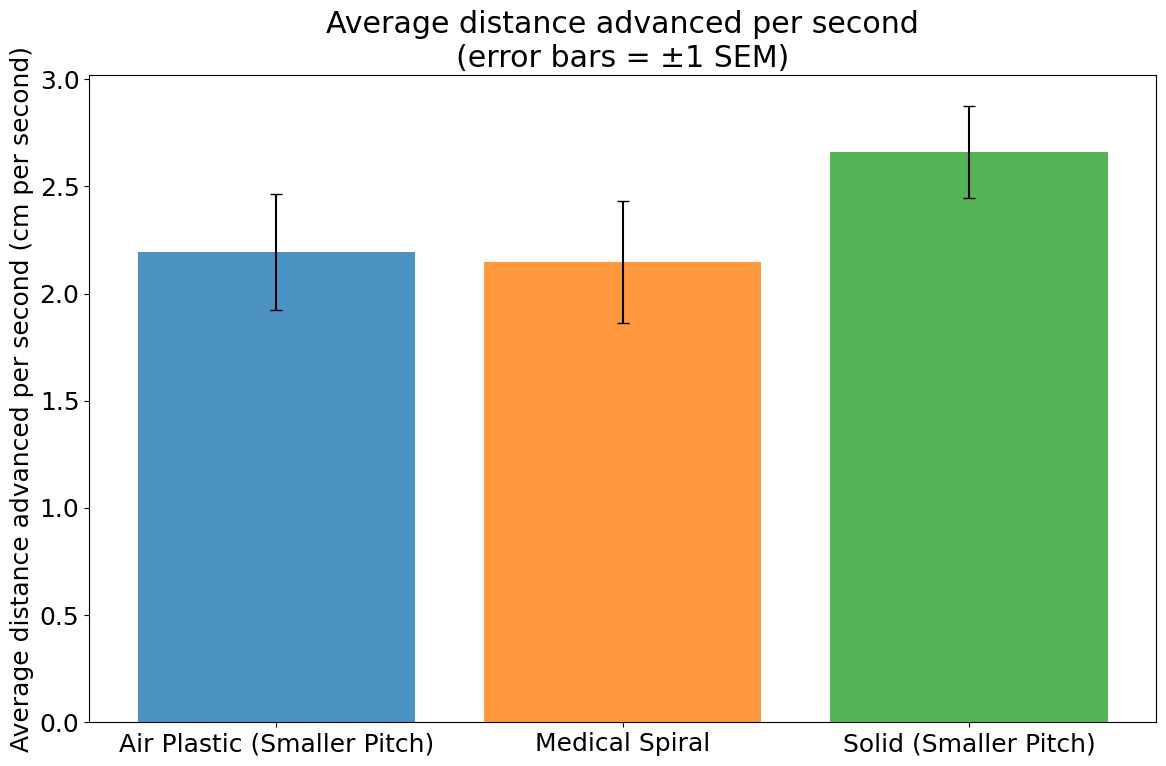

In [5]:
# Let's assume that we can move at 2 revolutions per second -> This means we get the following rate of movement

# divide all 
rates_long['rate_per_second'] = rates_long['rate'] * 2
rate_per_second_stats = (
    rates_long.groupby(spiral_col)["rate_per_second"]
              .agg(["mean", "std", "count"])
)
rate_per_second_stats["sem"] = rate_per_second_stats["std"] / np.sqrt(rate_per_second_stats["count"])

tableau_colors = ['tab:blue', 'tab:orange', 'tab:green'] # Example Tableau 10 colors


# ❸  Plot the bar chart
plt.figure(figsize=(12,8))
plt.bar(rate_per_second_stats.index,
        rate_per_second_stats["mean"],
        yerr=rate_per_second_stats["sem"],
        color=tableau_colors,
        alpha=0.8,
        capsize=4)

plt.ylabel("Average distance advanced per second (cm per second)")
plt.title("Average distance advanced per second\n(error bars = ±1 SEM)")
plt.tight_layout()
plt.savefig('Pleating Rate by Spiral Type.png')

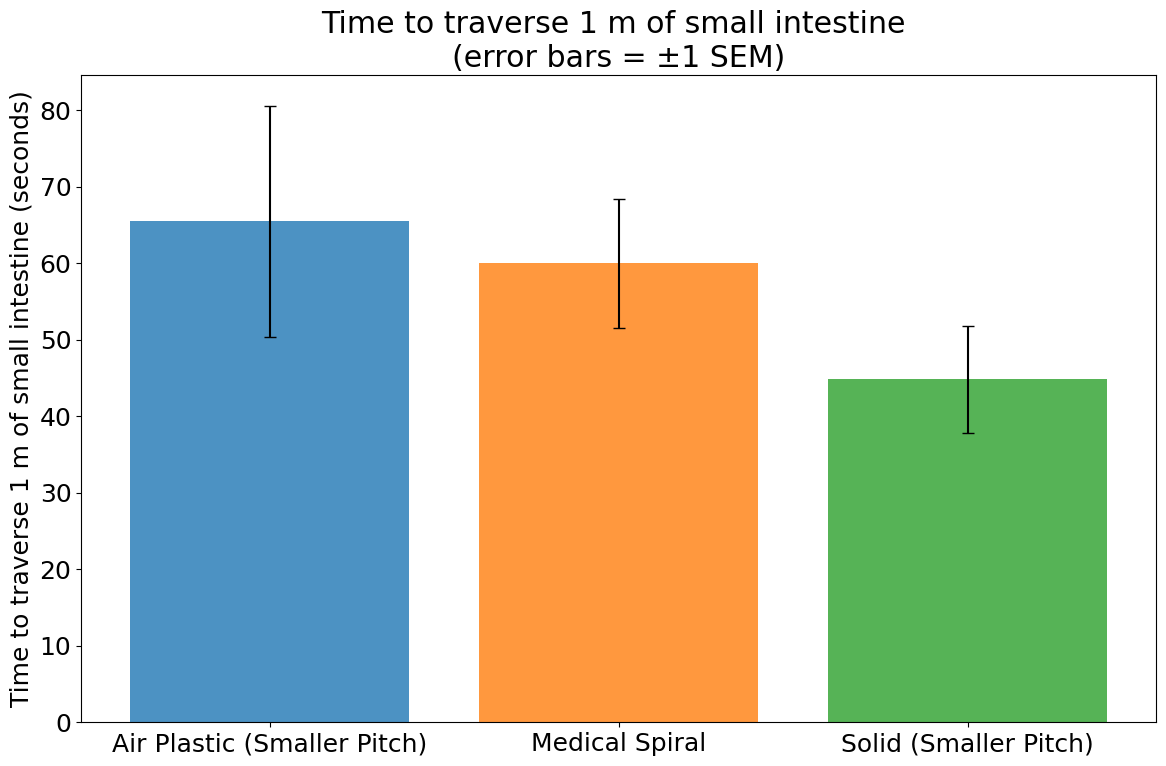

In [6]:
# and time it takes to traverse 200 cm of small intestine
rates_long['time_per_meter'] = 100 / rates_long['rate_per_second']

# ❷  Group by spiral and compute mean, SD, SEM of *all* these rates
rate_time_stats = (
    rates_long.groupby(spiral_col)["time_per_meter"]
              .agg(["mean", "std", "count"])
)
rate_time_stats["sem"] = rate_time_stats["std"] / np.sqrt(rate_time_stats["count"])

# ❸  Plot the bar chart
plt.figure(figsize=(12,8))
plt.bar(rate_time_stats.index,
        rate_time_stats['mean'],
        yerr=rate_time_stats['sem'],
        color=tableau_colors,
        alpha=0.8,
        capsize=4)

plt.ylabel("Time to traverse 1 m of small intestine (seconds)")
plt.title("Time to traverse 1 m of small intestine \n(error bars = ±1 SEM)")
plt.tight_layout()
plt.savefig('Time to Traverse 1 m of Small Intestine.png')

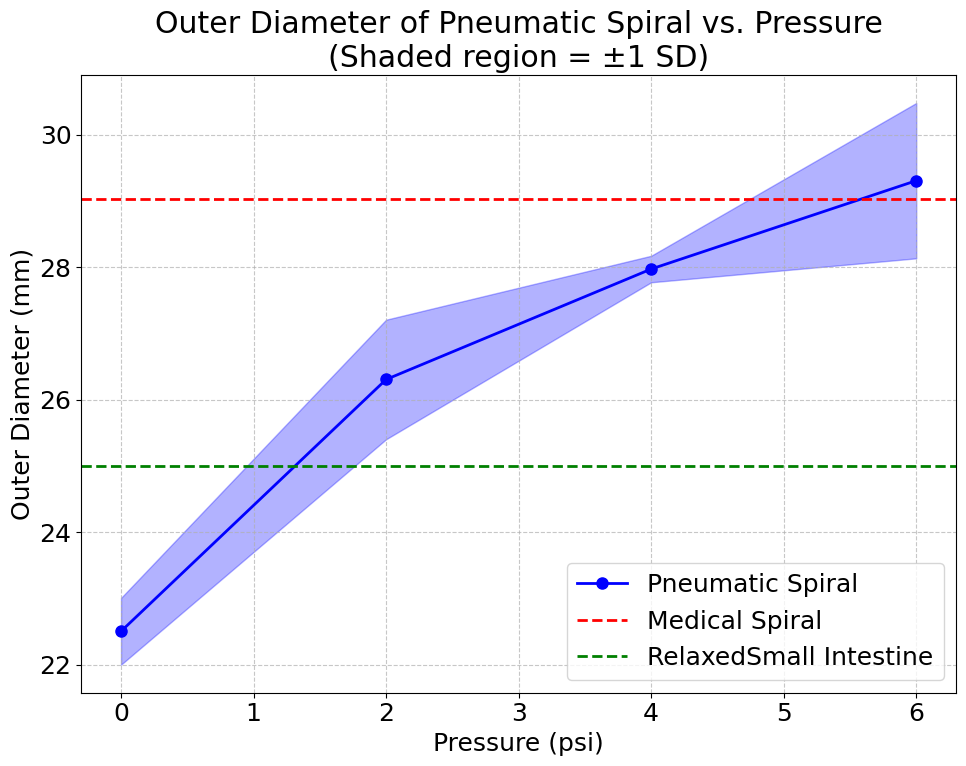

In [9]:
# Plot the Pressure vs. outer diameter distance

pressure_df = pd.read_csv("Cleaned_Pressure_Measurements_Data.csv")

inner_diameter = 18.03

# Create a new dataframe with adjusted pressure values
# Formula: inner_diameter + (value - inner_diameter)*2
# This effectively doubles the distance from inner_diameter

adjusted_pressure_df = pressure_df.copy()
for column in pressure_df.columns:
    if column != 'Pressure':  # Assuming 'Pressure' is a column we don't want to transform
        adjusted_pressure_df[column] = inner_diameter + (pressure_df[column] - inner_diameter) * 2

# Find the mean and standard deviation of each column in adjusted_pressure_df
mean_values = adjusted_pressure_df.mean()
std_values = adjusted_pressure_df.std()

# Extract pressure values from column names
pressure_values = [float(col.split()[0]) for col in adjusted_pressure_df.columns if 'psi' in col]

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'pressure': pressure_values,
    'mean': [mean_values[col] for col in adjusted_pressure_df.columns if 'psi' in col],
    'std': [std_values[col] for col in adjusted_pressure_df.columns if 'psi' in col]
})

# Sort by pressure to ensure correct plotting order
plot_df = plot_df.sort_values('pressure')

# Create the plot with shaded error region
plt.figure(figsize=(10, 8))
plt.plot(plot_df['pressure'], plot_df['mean'], 'o-', color='blue', linewidth=2, markersize=8, label = 'Pneumatic Spiral')
plt.fill_between(
    plot_df['pressure'], 
    plot_df['mean'] - plot_df['std'], 
    plot_df['mean'] + plot_df['std'],
    alpha=0.3, 
    color='blue'
)

# plot a horizontal line at the medical spiral outer diameter
plt.axhline(y=29.03, color='red', linestyle='--', linewidth=2, label = 'Medical Spiral')

# plot a horizontal line of the diameter of the intestine
small_intestine_diameter = 25
plt.axhline(y=small_intestine_diameter, color='green', linestyle='--', linewidth=2, label = 'RelaxedSmall Intestine')

# plot a horizontal line of the esophagus diameter


# Add labels and title
plt.xlabel('Pressure (psi)')
plt.ylabel('Outer Diameter (mm)')
plt.title('Outer Diameter of Pneumatic Spiral vs. Pressure\n(Shaded region = ±1 SD)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Outer Diameter of Pneumatic Spiral vs. Pressure.png')


